# This notebook shows the in silico evolution of near-enhancer sequences.
#### Kenyon Cell accessibility bigwig file is provided in ./data/near_enhancer_seq 
#### Chopped fly genome is provided in ./data/near_enhancer_seq 
#### It consists of:
* Calculating predictions on the 500bp chopped genomic sequences
* Plotting prediction scores vs chromatin accessibility
* Choosing sequences with low accessibility and high prediction score
* Plotting ATAC-seq coverage on chosen regions
* Performing additional in silico evolution mutations on the chosen regions
* Applying mutations to selected position and substation to create repressor binding sites
#### Intermediate files are saved to ./data/near_enhancer_seq folder
#### Figures are saved to ./figures/near_enhancer_seq folder

### General imports


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### Loading DeepFlyBrain data to be used for the initialization of shap.DeepExplainer


In [2]:
print('Loading data...')
f = open('./data/deepflybrain/DeepFlyBrain_nonAugmented_data.pkl', "rb")
nonAugmented_data_dict = pickle.load(f)
f.close()

Loading data...


### Loading the model and initializing shap.DeepExplainer


In [3]:
print('Loading model...')
import shap
tf.disable_eager_execution()
rn=np.random.choice(nonAugmented_data_dict["train_data"].shape[0], 250, replace=False)
model_dict = {}
exp_dict = {} 

name = "DeepFlyBrain"
model_json_file = "models/deepflybrain/model.json"
model_hdf5_file = "models/deepflybrain/model_epoch_83.hdf5"
model_dict[name] = utils.load_model(model_json_file, model_hdf5_file)
exp_dict[name] = shap.DeepExplainer((model_dict[name].inputs, model_dict[name].layers[-1].output), nonAugmented_data_dict["train_data"][rn])


Loading model...


In [4]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### Calculating predictions on the 500bp chopped genomic sequences

In [5]:
# w500_s50 = utils.prepare_data_wolabel("data/near_enhancer_seq/dm6_w500_s50_fixed.fa")
# w500_s50_dict = {"ids":np.array(w500_s50[1]),"X":w500_s50[0]}
# w500_s50_dict["prediction"] = model_dict["DeepFlyBrain"].predict(w500_s50_dict["X"])
# f = open("data/near_enhancer_seq/w500_s50_dict.pkl", "wb")
# pickle.dump(w500_s50_dict,f,protocol=4)
# f.close()

### Calculating Gamma Kenyon Cell ATAC-seq coverage on the 500bp chopped genomic sequences

In [6]:
# import pyBigWig
# bw_atac_kcg = pyBigWig.open("data/near_enhancer_seq/KC_G.dedup.no_blacklist.RPGCnormalized.bw")

# g_kc_acc = [] 
# for id_ in w500_s50_dict["ids"]:
#     chr_ = id_.split(":")[0]
#     str_ = int(id_.split(":")[1].split("-")[0])
#     end_ = int(id_.split(":")[1].split("-")[1])
#     try:
#         g_kc_acc.append(bw_atac_kcg.stats(chr_.strip("chr"),str_,end_)[0])
#     except:
#         g_kc_acc.append(0)

# f = open("data/near_enhancer_seq/w500_s50_g_kc_acc.pkl", "wb")
# pickle.dump(g_kc_acc,f,protocol=4)
# f.close()

In [7]:
f = open("/staging/leuven/stg_00002/lcb/itask/files/genomes/dm6/chop/w500_s50_dict.pkl", "rb")
w500_s50_dict = pickle.load(f)
f.close()
f = open("/staging/leuven/stg_00002/lcb/itask/files/genomes/dm6/chop/w500_s50_g_kc_acc.pkl", "rb")
g_kc_acc = pickle.load(f)
f.close()

### Plotting prediction scores vs chromatin accessibility with highlighting selected near-enhancer sequences

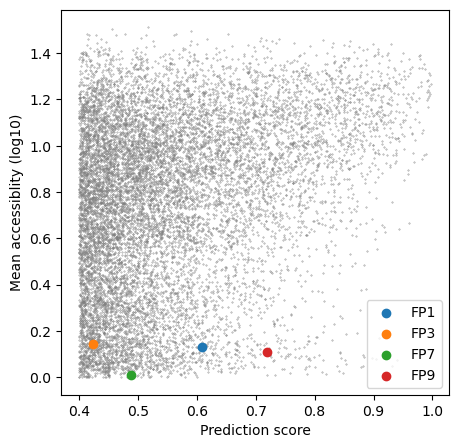

In [19]:
plt.figure(figsize=(5,5))
plt.scatter((w500_s50_dict["prediction"][:,34])[w500_s50_dict["prediction"][:,34]>0.4],np.log10(np.array(g_kc_acc)+1)[w500_s50_dict["prediction"][:,34]>0.4],s=0.1,color="gray")
plt.scatter(w500_s50_dict["prediction"][w500_s50_dict["ids"]=="chr3L:8670850-8671350"][:,34][0],np.log10(np.array(g_kc_acc)+1)[w500_s50_dict["ids"]=="chr3L:8670850-8671350"][0],label="FP1")
plt.scatter(w500_s50_dict["prediction"][w500_s50_dict["ids"]=="chrX:15547650-15548150"][:,34][0],np.log10(np.array(g_kc_acc)+1)[w500_s50_dict["ids"]=="chrX:15547650-15548150"][0],label="FP3")
plt.scatter(w500_s50_dict["prediction"][w500_s50_dict["ids"]=="chrX:4010500-4011000"][:,34][0],np.log10(np.array(g_kc_acc)+1)[w500_s50_dict["ids"]=="chrX:4010500-4011000"][0],label="FP7")
plt.scatter(w500_s50_dict["prediction"][w500_s50_dict["ids"]=="chrX:9786300-9786800"][:,34][0],np.log10(np.array(g_kc_acc)+1)[w500_s50_dict["ids"]=="chrX:9786300-9786800"][0],label="FP9")
#plt.scatter(w500_s50_dict["prediction"][w500_s50_dict["ids"]=="chr2R:22281900-22282400"][:,34][0],np.log10(np.array(g_kc_acc)+1)[w500_s50_dict["ids"]=="chr2R:22281900-22282400"][0],label="FP5")
plt.legend()

plt.xlabel("Prediction score")
plt.ylabel("Mean accessiblity (log10)")
plt.savefig("figures/near_enhancer_seq/prediction_vs_acc_FP1_FP3_FP7_FP9.pdf",transparent=True,dpi=300)


### Performing in silico evolution mutations on the selected regions

In [12]:
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

for id_ in ['chr3L:8670850-8671350','chrX:15547650-15548150','chrX:4010500-4011000','chrX:9786300-9786800']:
    print(id_)
    start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
    for i in range(10):
        mutagenesis_X = utils.create_saturation_mutagenesis_x(start_x)
        prediction_mutagenesis_X = model_dict["DeepFlyBrain"].predict(mutagenesis_X["X"])
        original_prediction = model_dict["DeepFlyBrain"].predict(start_x)
        next_one = mutagenesis_X["ids"][np.argmax((prediction_mutagenesis_X[:,34]-original_prediction[:,34]))]
        print(next_one,end=',')
        start_x[0][int(next_one.split("_")[0]),:] = np.array(nuc_to_onehot[next_one.split("_")[1]], dtype='int8')
    print("")

chr3L:8670850-8671350
287_C,443_A,366_G,149_A,420_G,424_C,276_T,436_A,216_A,337_C,
chrX:15547650-15548150
426_C,283_C,264_C,260_T,254_C,261_G,222_C,153_A,176_T,407_C,
chrX:4010500-4011000
394_C,228_G,453_C,258_G,212_T,358_T,357_C,121_T,429_G,466_A,
chrX:9786300-9786800
273_A,282_A,342_G,278_C,297_C,109_A,350_A,359_G,382_A,442_G,


In [ ]:
# # FP-1
# id_ =  'chr3L:8670850-8671350'
# muts = ["287_C","443_A","366_G","149_A","420_G","424_C"]

# # FP-3
# id_ =  'chrX:15547650-15548150'
# muts = ["426_C","283_C","264_C","260_T","254_C","176_C"]

# # FP-7
# id_ =  'chrX:4010500-4011000'
# muts = ["394_C","228_G","453_C","258_G","429_G","214_G"]

# # FP-9
# id_ =  'chrX:9786300-9786800'
# muts = ["273_A","282_A","342_G","278_C","297_C","109_A"]


### Plotting nucleotide contribution scores at different mutational steps

0,1,2,3,4,5,

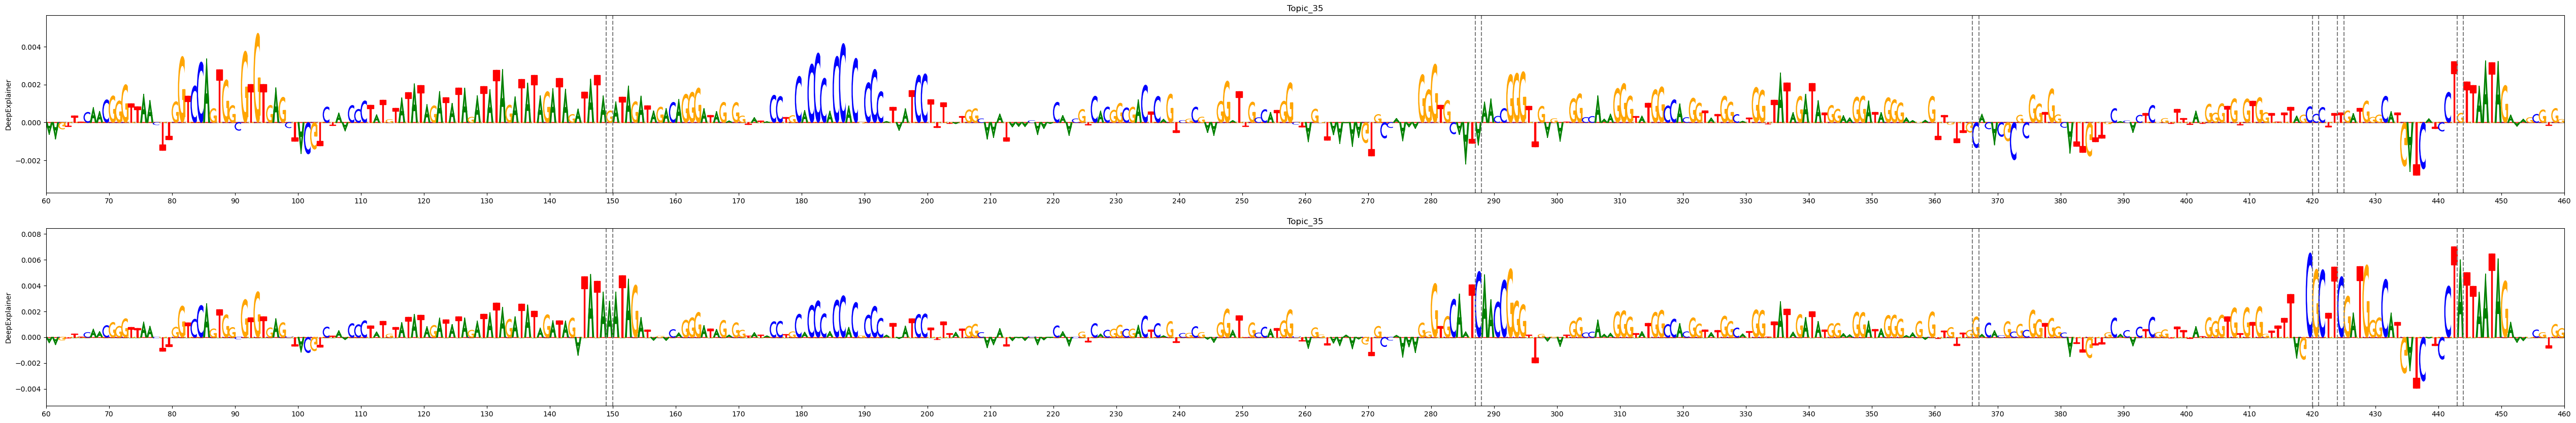

In [18]:
id_ =  'chr3L:8670850-8671350'
muts = ["287_C","443_A","366_G","149_A","420_G","424_C"]
st = 60
end = 460

start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
ntrack = 2
fig = plt.figure(figsize=(64,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
plt.savefig("figures/near_enhancer_seq/FP12_deepexplainer_mut0_mut6_st60_end460.pdf",transparent=True)


### Printing nucleotide sequences of evolved near-enhancer sequences

In [21]:
id_ =  'chr3L:8670850-8671350'
muts = ["287_C","443_A","366_G","149_A","420_G","424_C"]
start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
for nuc in start_x[0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")
print("")

TGTACTTGGCCAAAAGAGCCGTTCGCATCGCTCTCTTTGCTAAAATCCTCTCCAGAACTCAAGTTTCAACGGGTTAACTTGGTCCAGTGGCGTGTGAGCTACGTCTAACCCTATGTATATAGATATAGATATAGATATAGATAGATATAAATAGATAGACAGGGATAGAGGTATACCTGCACCCACCACGCCCATAATCCTTTTATGGCAAATAAACAAACAACGTCACGGCGACTCAGTCGCGAAGGATTGCCATGGCTAGGTAAAAAGTGCCAAAAGGGTGCAATCAACCGGGTTGAGATGGCCAAAGGGTATGGCCACGGTATGGCATGGTTATAGATATGGAAGGATAGGGAAGAGTTGTTGGACACGCGCGGTGGCATTGTTGCACACTCGGTTTTATGGGTGTGTGGTTTTAGCGCTTCGATGGGCATGATCATCCTATTAATAGAAAGCGTGGAAACCCGTTGCAACTTGTAACCCTACCTGCACGCCCAACC


0,1,2,3,4,5,

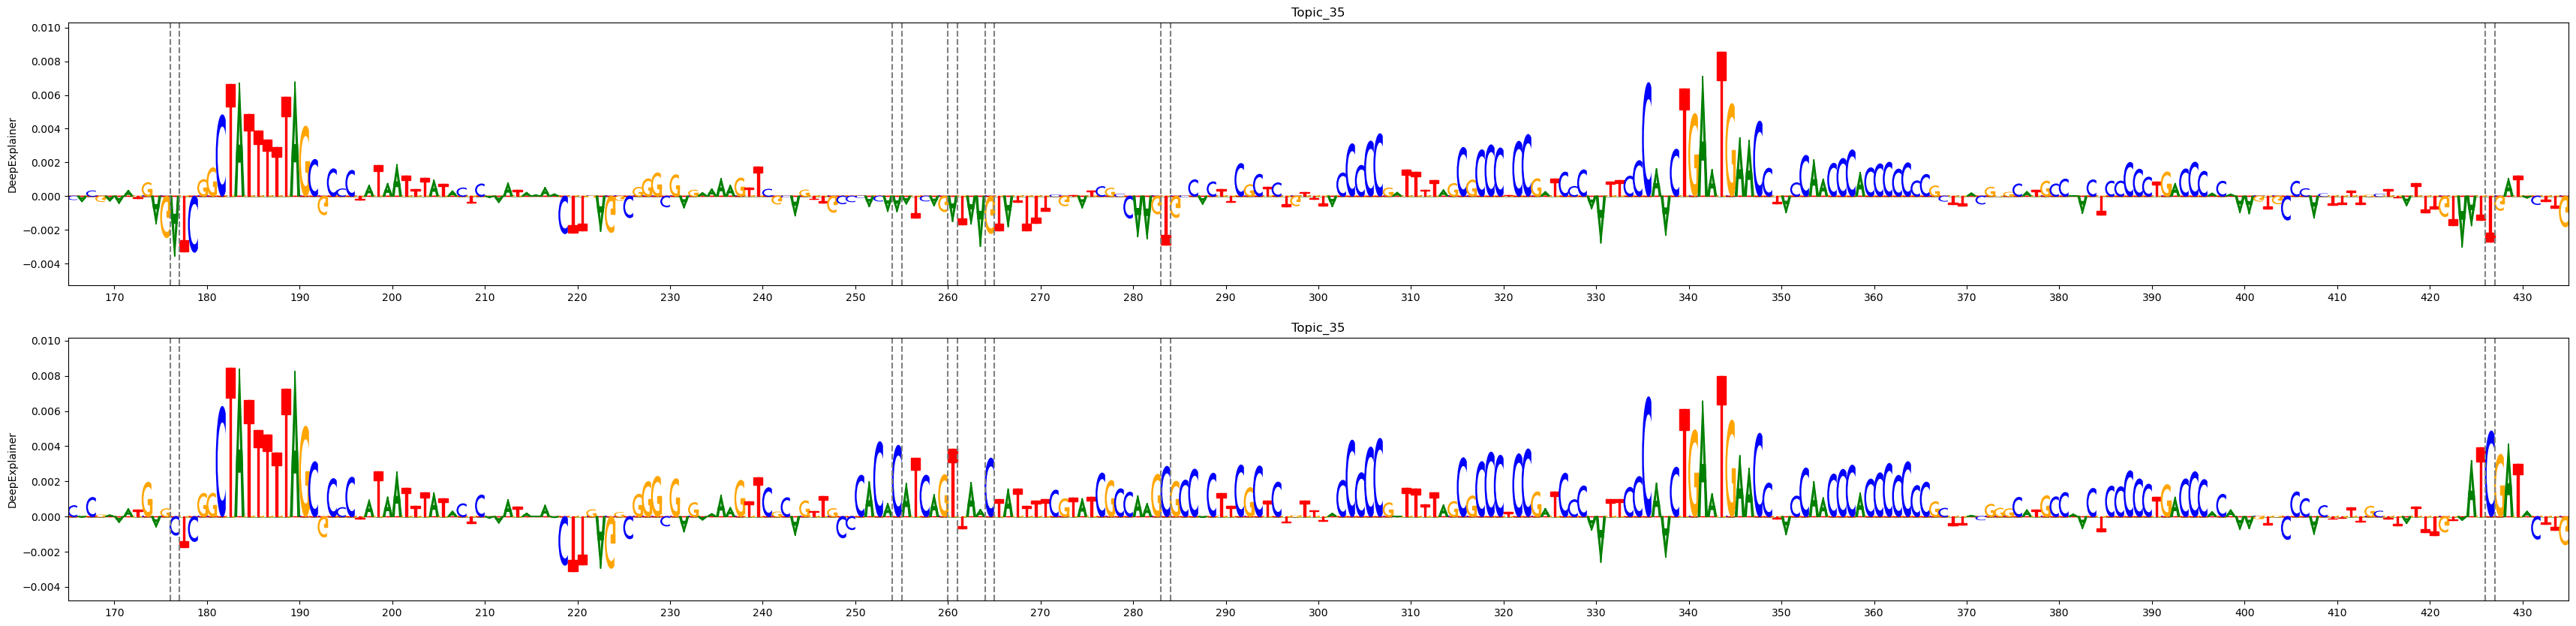

In [14]:
id_ =  'chrX:15547650-15548150'
muts = ["426_C","283_C","264_C","260_T","254_C","176_C"]
st = 165
end = 435

start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
ntrack = 2
fig = plt.figure(figsize=(43,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
plt.savefig("figures/near_enhancer_seq/FP34_deepexplainer_mut0_mut6_st165_end435.pdf",transparent=True)


In [22]:
id_ =  'chrX:15547650-15548150'
muts = ["426_C","283_C","264_C","260_T","254_C","176_C"]
start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
for nuc in start_x[0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")
print("")

CACAAGTGTCTGTCTGGCCAAAACGGAAAGTTGAAACGTCAGTTGCAGGAGACTCTGTTGGCCAAATGTAAGCCGATATCCCGGGGCTGCTGTCACCAGAAGAAGAACTCGTATCCTCGAGATACACTCGCACAGCCATGCTCACTGATGCAGTCCGTTGATGCCCACGAAATGAGCTCGGCTATTTTTAGCGCCCTATAATTTATACTCAAATAAAACTTGAGGCGGGCGAGAAAAGTTCGCAGTTGCCCACACATCAGTTAACTATTTTCGTATCGCCAAGCGCCACTTCGCTCTGTTTACCCCCGATTTTAGCGCCCTCCGATCCCAATTCCCAACTGAATGAACCTACCAACCCACCCCCCCGCTTACGGGCATGCCAACTCCCCCTGACCCACAAAGTGCCCACTTTTGCTTATTTGTAATCGATACTTGATCTGGTGGAGCGTATAAAAGCCACTTTAGGCGTTGCCATTACGTCACCTTGAGTCAGCCTTAGC


0,1,2,3,4,5,

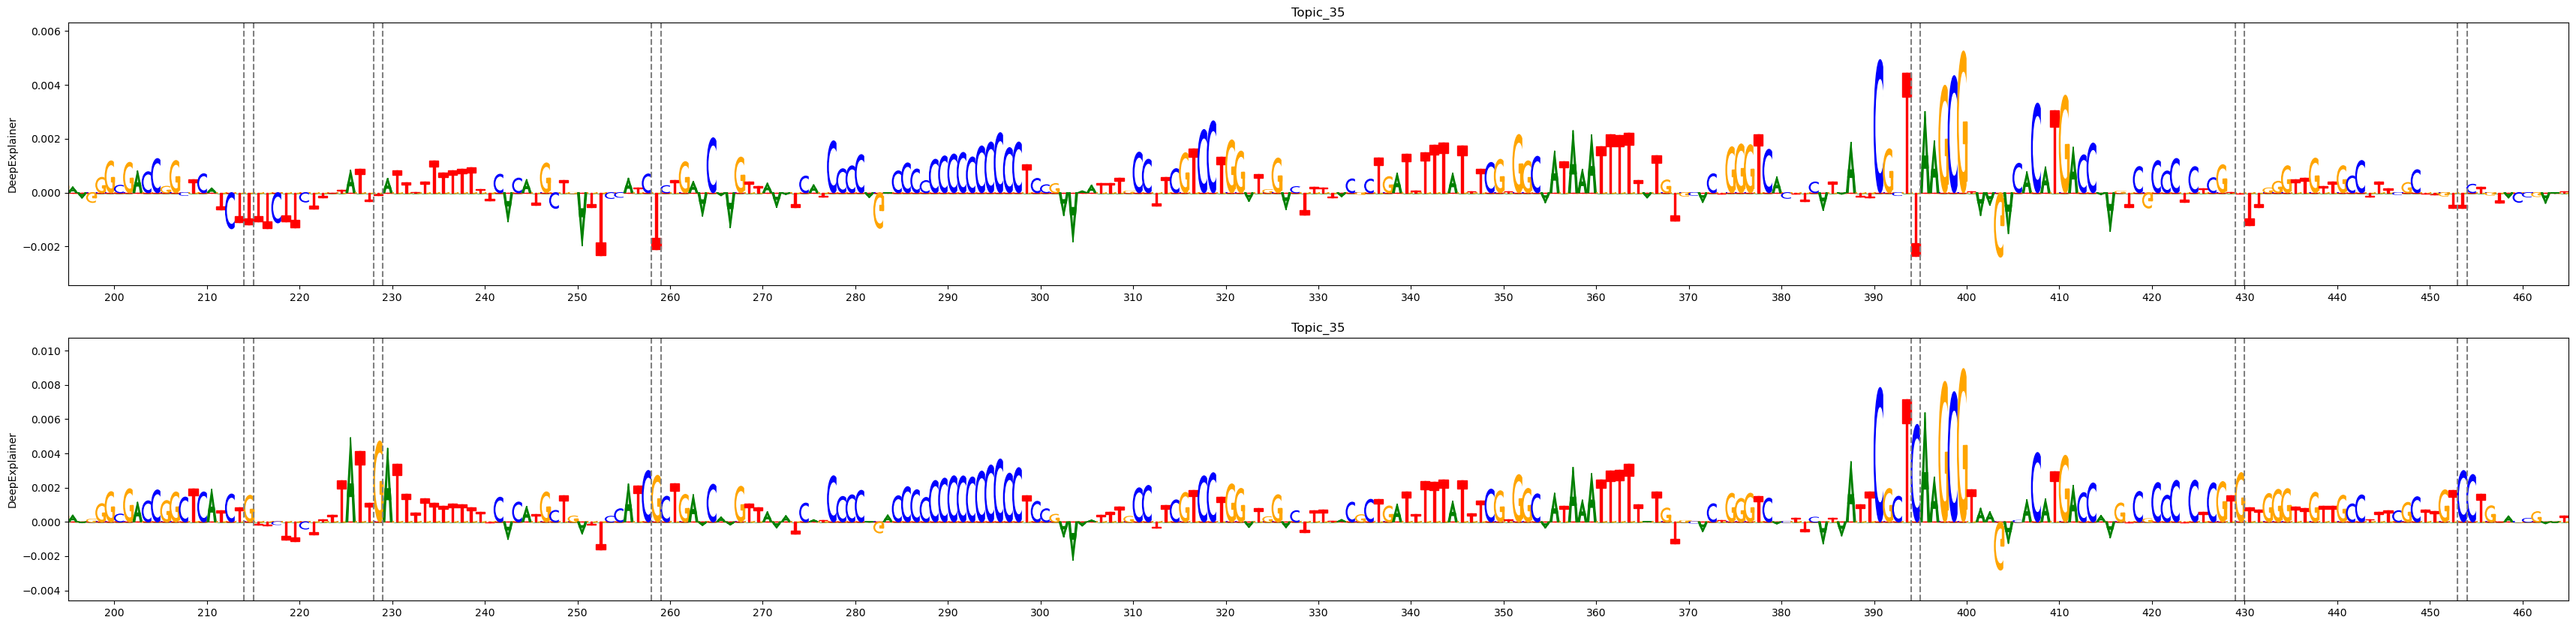

In [15]:
id_ =  'chrX:4010500-4011000'
muts = ["394_C","228_G","453_C","258_G","429_G","214_G"]
st = 195
end = 465

start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
ntrack = 2
fig = plt.figure(figsize=(43,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
plt.savefig("figures/near_enhancer_seq/FP78_deepexplainer_mut0_mut6_st195_end465.pdf",transparent=True)


In [25]:
id_ =  'chrX:4010500-4011000'
muts = ["394_C","228_G","453_C","258_G","429_G","214_G"]
start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
for nuc in start_x[0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")
print("")

CAACAATAAAGATGGACAGATGTTGGCGATATGGAGTACTCGTTGTACACAGGGATGAGGCTTATAAATATATTTGCCTCACTTAAAGTGACCAAATTGTTATCATGATGATATGTGTTAAGATTAAAAGGACTTTCTTGTCCCTGTCCGTTTGCTGCTGGCGGGCATGAGGAGGGGATTCAATGGACTTACCAGAAGGGCGACCGGCTCATCTGTTCTTCTTTTATTGATTTTTTTTTTTCACATGCTGATTCCATCGCTGAACAAGTTAAATCATCCCCAGACCCCCCCCCCCCCCTCCGAAAATTTGCCTTCGTCCTGGATGGACTTTTACGCTGATTTTTATTTCGTGGCAATAAATTTTTATGTGCACTGGGTCACTTCATAATTCGCTCAAGCGTAAGACACATGACCAAGTCGCCCTCTCGTGTTGGGTTGTTGCCTTTCGCTTGTCCTGTACCGAATGCACTGGGAGAAATATTATCATAGTAACGAAATCA


0,1,2,3,4,5,

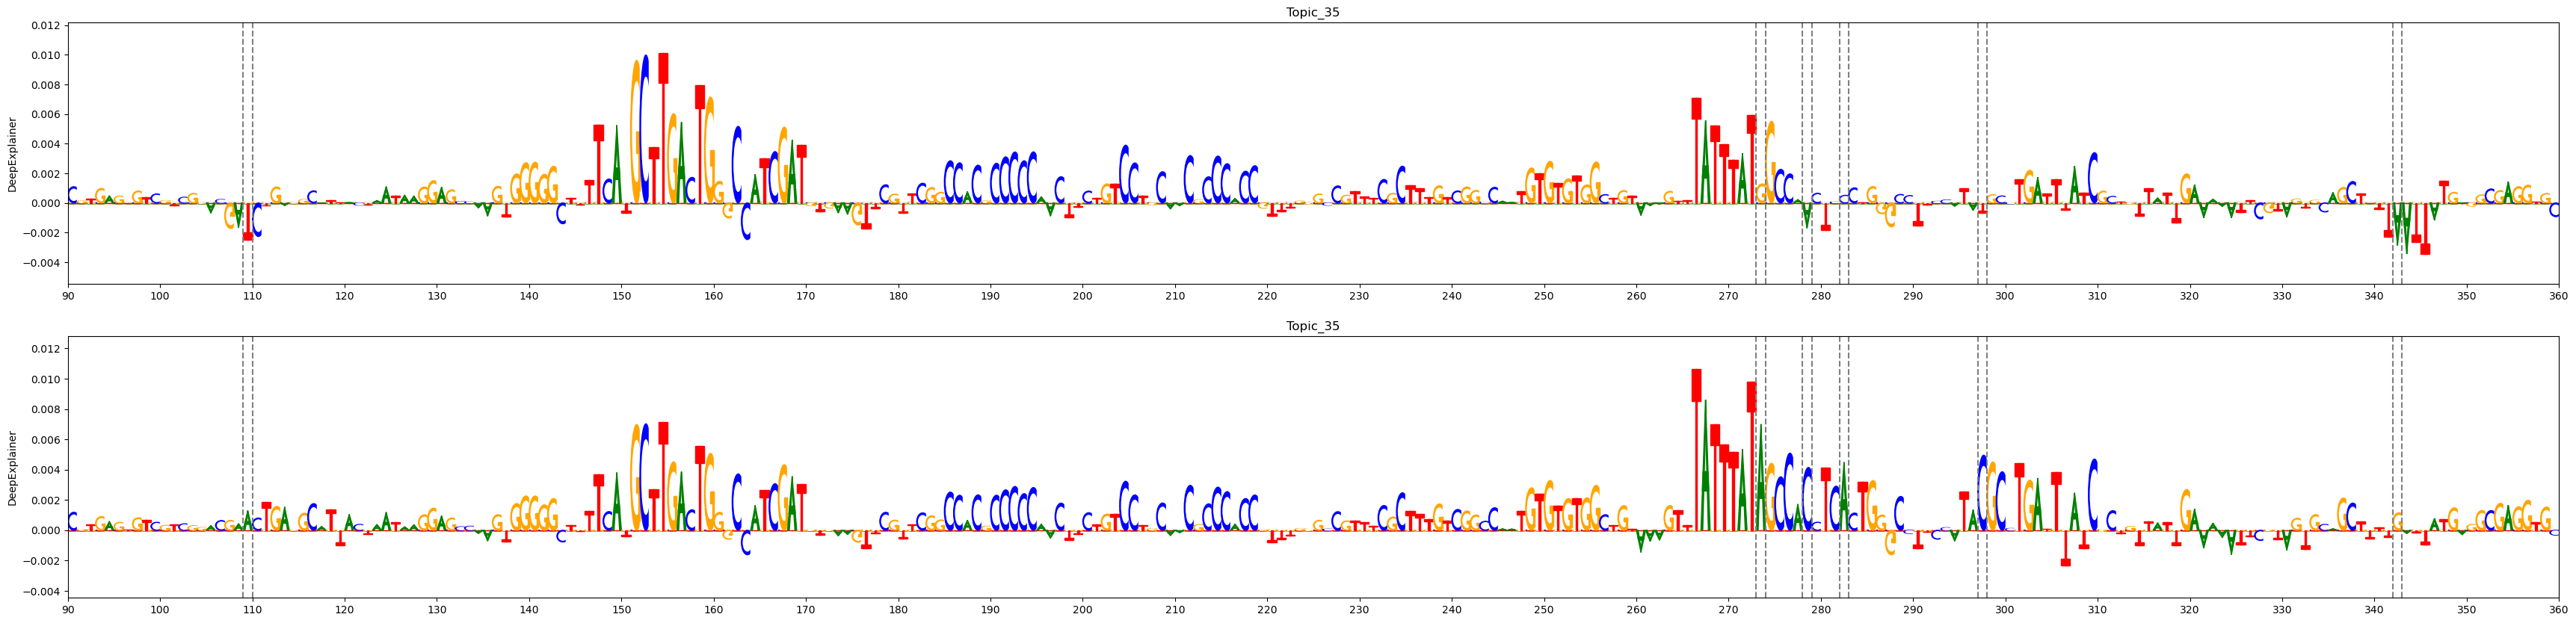

In [16]:
id_ =  'chrX:9786300-9786800'
muts = ["273_A","282_A","342_G","278_C","297_C","109_A"]
st = 90
end = 360

start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
ntrack = 2
fig = plt.figure(figsize=(43,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    ax1.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax1.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")
ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
plt.savefig("figures/near_enhancer_seq/FP910_deepexplainer_mut0_mut6_st90_end360.pdf",transparent=True)


In [24]:
id_ =  'chrX:9786300-9786800'
muts = ["273_A","282_A","342_G","278_C","297_C","109_A"]
start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
for nuc in start_x[0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")
print("")

AATGAATATTTTAAACCTTTCATTTCCATCTTTAATAACATAATTTTCATCTGGTTTAATTCGCTTTCCTCGACTTTCGATTGCATTTACCGTGAGTGTCGTCGGACGAACTGAGGCATTACTAATAAGGAGCCAAGTGGGGGCTTTTCATGCTTGACTGGGCCATCGATGTGAAGTTCGTTCGGCCACGCCCCCAACTTCTGTCCTGCAACGCCCACCGTTTGGGCCGTTTCGCTTTGTCGGCCAATGTGTGTGGCTGTAAAGTTTATTTATAGCCACCTCACTGGGCCTTCCATACGCCTGATTTATCGCTGTTATTGAAAAATTCGTAGTGCAGCTTTTGATTATGAGGCGAGGTGCAAACAGAAAAATGGGTATATATTACAACAACATAAAAATAAAAGAGTGCAAAAATAAACAACATATAGCCGAGTGCAGAGTGAATAGTGCTGACTGCAAATCCCCTGGCAAACAAATAAATTGGAAAGTGGGCAAAACTG


### General imports


In [10]:
import pyBigWig
import seaborn as sns
import matplotlib.patches as mpatches

### Calculating Gamma Kenyon Cell ATAC-seq coverage on the selected genomic sequences

In [11]:
bw_atac_kcg = pyBigWig.open("data/near_enhancer_seq/KC_G.dedup.no_blacklist.RPGCnormalized.bw")

acc_list = [] 
for id_ in ['chr3L:8670850-8671350', 'chrX:15547650-15548150', 'chrX:4010500-4011000', 'chrX:9786300-9786800']:
    chr_ = id_.split(":")[0]
    str_ = int(id_.split(":")[1].split("-")[0])-15000
    end_ = int(id_.split(":")[1].split("-")[1])+15000
    try:
        acc_list.append(bw_atac_kcg.values(chr_.strip("chr"),str_,end_))
    except:
        acc_list.append(0)

### Plotting Gamma Kenyon Cell ATAC-seq coverage on the selected genomic sequences

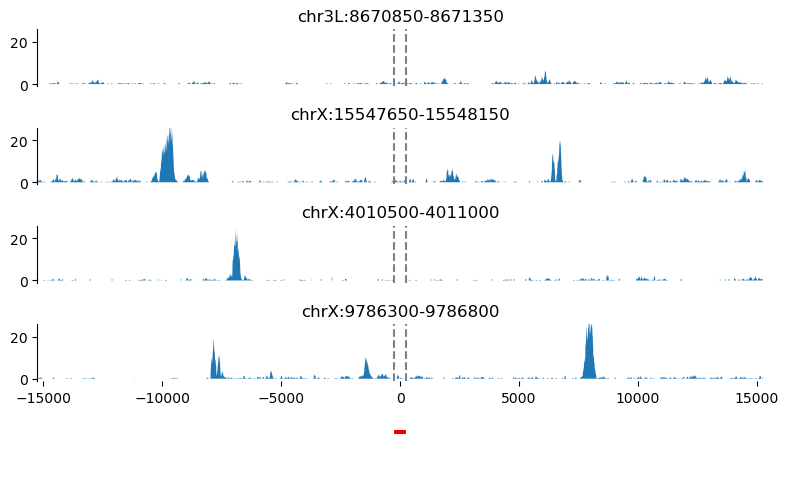

In [104]:
n_tracks = 5
fig = plt.figure(figsize=(8,1*n_tracks))
start = -15250
end = 15250
for i, id_ in enumerate(['chr3L:8670850-8671350', 'chrX:15547650-15548150', 'chrX:4010500-4011000', 'chrX:9786300-9786800']):
    ax  = fig.add_subplot(n_tracks,1,i+1)
    ax.fill_between(np.linspace(start, end, num=len(acc_list[i])),0,acc_list[i]) 
    ax.set_title(id_)
    ax.margins(x=0)
    if i!=3:
        ax.set_xticks([])
    ax.set_ylim([-1,26])
    ax.axvline(x=-250,linestyle="--",color='gray')
    ax.axvline(x=250,linestyle="--",color='gray')
    #ax.set_xticks(range(-15250,15250,1000),list(range(-15250,15250,1000)))

sns.despine(top=True, right=True, bottom=True)

ax  = fig.add_subplot(n_tracks,1,5)
rect = mpatches.Rectangle((-250, 1), 500, 0.2, fill=True, color="r", linewidth=0)
ax.add_patch(rect)
ax.set_ylim([-2/1.2, 2/1.2])
ax.set_xlim([start, end])
sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0)

fig.tight_layout()
plt.savefig("figures/near_enhancer_seq/accessiblity_FP1_FP3_FP7_FP9_30kb.pdf",transparent=True,dpi=300)


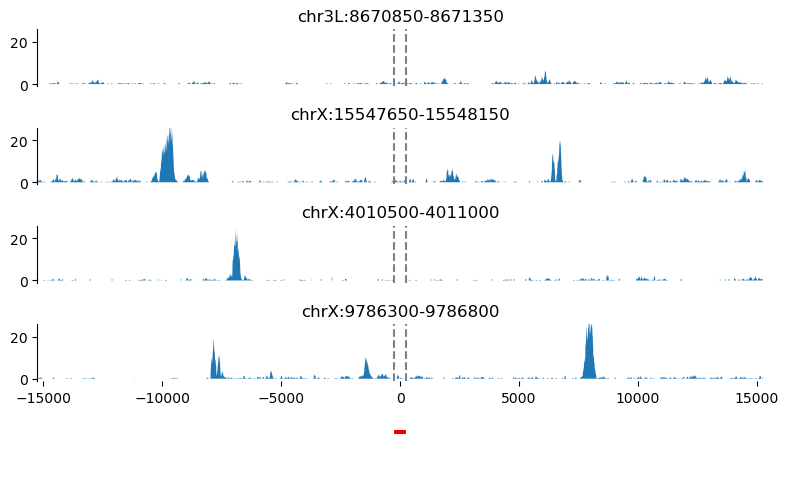

In [14]:
n_tracks = 5
fig = plt.figure(figsize=(8,1*n_tracks))
start = -15250
end = 15250
for i, id_ in enumerate(['chr3L:8670850-8671350', 'chrX:15547650-15548150', 'chrX:4010500-4011000', 'chrX:9786300-9786800']):
    ax  = fig.add_subplot(n_tracks,1,i+1)
    ax.fill_between(np.linspace(start, end, num=len(acc_list[i])),0,acc_list[i]) 
    ax.set_title(id_)
    ax.margins(x=0)
    if i!=3:
        ax.set_xticks([])
    ax.set_ylim([-1,26])
    ax.axvline(x=-250,linestyle="--",color='gray')
    ax.axvline(x=250,linestyle="--",color='gray')
    #ax.set_xticks(range(-15250,15250,1000),list(range(-15250,15250,1000)))

sns.despine(top=True, right=True, bottom=True)

ax  = fig.add_subplot(n_tracks,1,5)
rect = mpatches.Rectangle((-250, 1), 500, 0.2, fill=True, color="r", linewidth=0)
ax.add_patch(rect)
ax.set_ylim([-2/1.2, 2/1.2])
ax.set_xlim([start, end])
sns.despine(top=True, right=True, left=True, bottom=True, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.patch.set_alpha(0)

fig.tight_layout()
plt.savefig("figures/near_enhancer_seq/accessiblity_FP1_FP3_FP7_FP9_30kb.png",dpi=1200)


### Applying mutations to selected position and substation to create repressor binding sites

0,1,2,3,4,5,0,1,2,3,4,5,6,7,

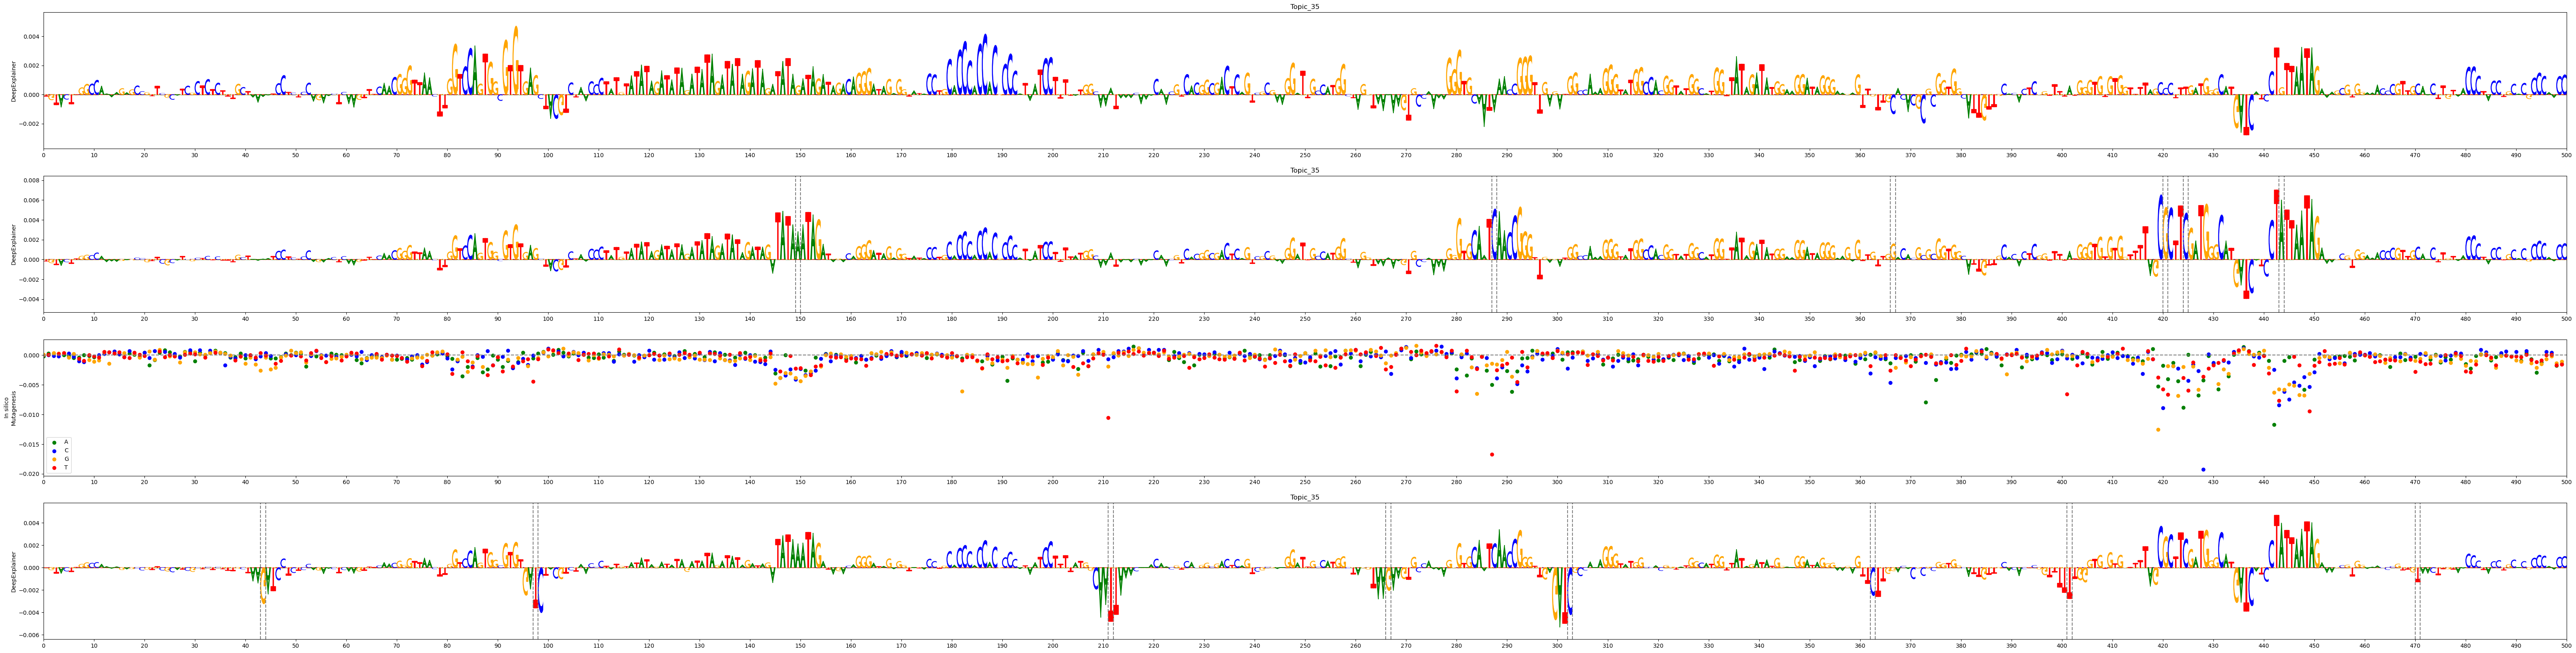

In [105]:
id_ =  'chr3L:8670850-8671350'
muts = ["287_C","443_A","366_G","149_A","420_G","424_C"]
st = 0
end = 500

start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
ntrack = 4
fig = plt.figure(figsize=(80,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
ax_ = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)

repr_muts = ["211_T","401_T","302_C","97_T","43_G","266_G","470_T","362_C"]
for i, mut_ in enumerate(repr_muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 35)

for i, mut_ in enumerate(muts):
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

for i, mut_ in enumerate(repr_muts):
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

    
ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax_.set_xlim([st,end])

plt.savefig("figures/near_enhancer_seq/FP12_deepexplainer_mut0_mut6_repr_st0_end500.pdf",transparent=True)


In [106]:
id_ =  'chr3L:8670850-8671350'
muts = ["287_C","443_A","366_G","149_A","420_G","424_C"]
repr_muts = ["211_T","401_T","302_C","97_T","43_G","266_G","470_T","362_C"]

start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
for i, mut_ in enumerate(repr_muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

for nuc in start_x[0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")
print("")

TGTACTTGGCCAAAAGAGCCGTTCGCATCGCTCTCTTTGCTAAGATCCTCTCCAGAACTCAAGTTTCAACGGGTTAACTTGGTCCAGTGGCGTGTGATCTACGTCTAACCCTATGTATATAGATATAGATATAGATATAGATAGATATAAATAGATAGACAGGGATAGAGGTATACCTGCACCCACCACGCCCATAATCCTTTTATGGCAATTAAACAAACAACGTCACGGCGACTCAGTCGCGAAGGATTGCCATGGCTAGGTAAGAAGTGCCAAAAGGGTGCAATCAACCGGGTTGAGATCGCCAAAGGGTATGGCCACGGTATGGCATGGTTATAGATATGGAAGGATAGGGAAGAGTTCTTGGACACGCGCGGTGGCATTGTTGCACACTCGGTTTTTTGGGTGTGTGGTTTTAGCGCTTCGATGGGCATGATCATCCTATTAATAGAAAGCGTGGAAACCCGTTGTAACTTGTAACCCTACCTGCACGCCCAACC


### Applying mutations to selected position and substation to create repressor binding sites

0,1,2,3,4,5,0,1,2,3,4,5,6,7,

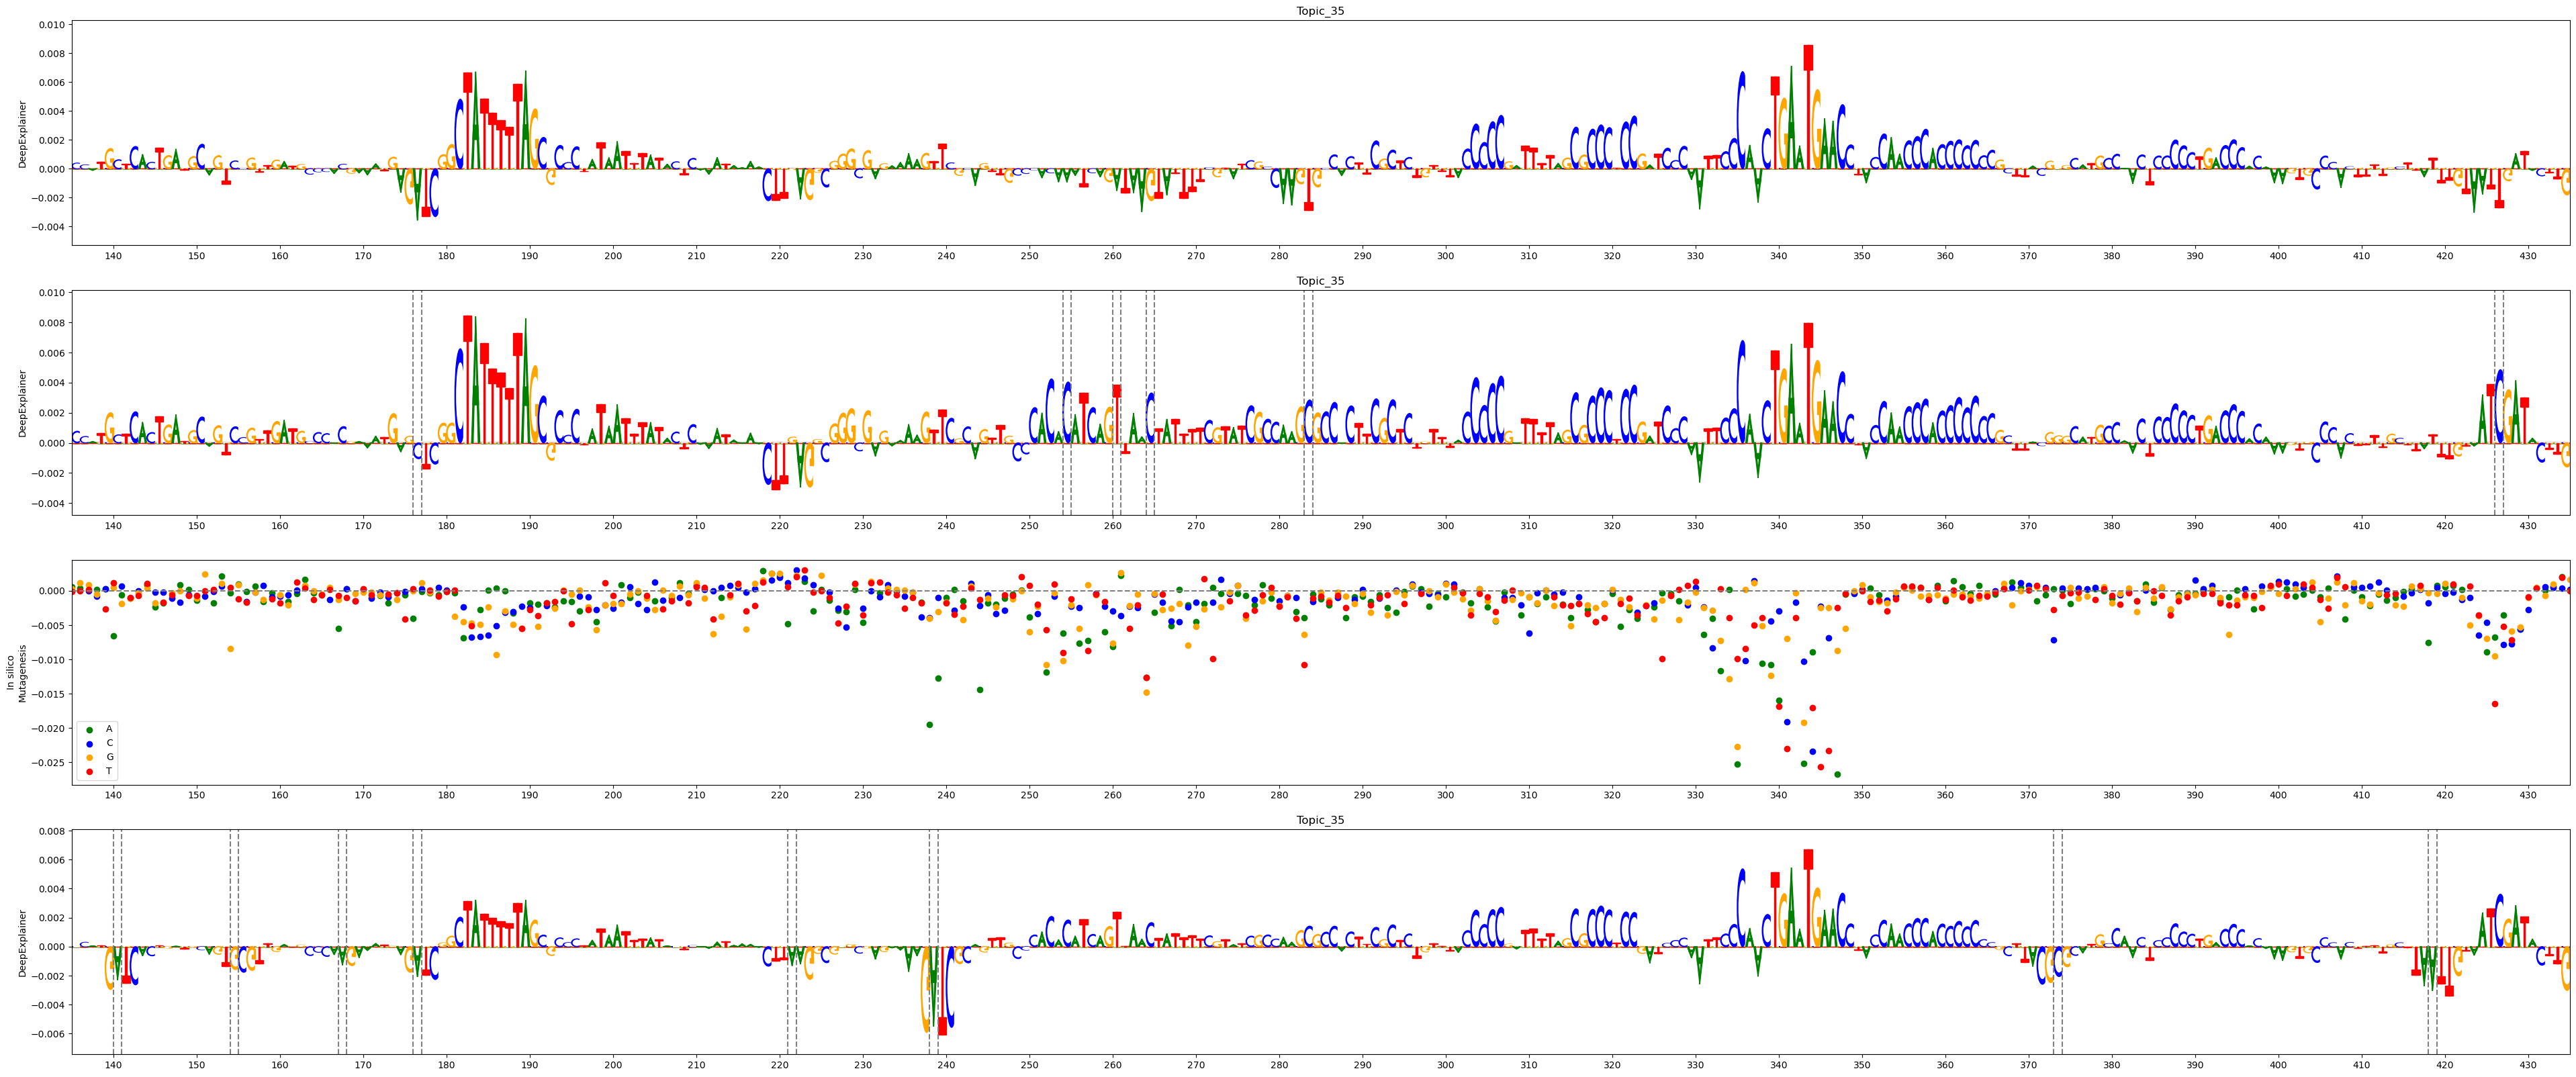

In [107]:
id_ =  'chrX:15547650-15548150'
muts = ["426_C","283_C","264_C","260_T","254_C","176_C"]
st = 135
end = 435


start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
ntrack = 4
fig = plt.figure(figsize=(48,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
ax_ = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)

repr_muts = ["238_A","154_G","373_C","167_A","140_A","176_A","221_A","418_A"]
for i, mut_ in enumerate(repr_muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 35)

for i, mut_ in enumerate(muts):
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

for i, mut_ in enumerate(repr_muts):
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")


ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax_.set_xlim([st,end])

plt.savefig("figures/near_enhancer_seq/FP34_deepexplainer_mut0_mut6_repr_st135_end435.pdf",transparent=True)


In [108]:
id_ =  'chrX:15547650-15548150'
muts = ["426_C","283_C","264_C","260_T","254_C","176_C"]
repr_muts = ["238_A","154_G","373_C","167_A","140_A","176_A","221_A","418_A"]

start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
for i, mut_ in enumerate(repr_muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

for nuc in start_x[0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")
print("")

CACAAGTGTCTGTCTGGCCAAAACGGAAAGTTGAAACGTCAGTTGCAGGAGACTCTGTTGGCCAAATGTAAGCCGATATCCCGGGGCTGCTGTCACCAGAAGAAGAACTCGTATCCTCGAGATACACTCGCACAGCCATGATCACTGATGCAGTGCGTTGATGCCCAAGAAATGAGATCGGCTATTTTTAGCGCCCTATAATTTATACTCAAATAAAACTTAAGGCGGGCGAGAAAAGATCGCAGTTGCCCACACATCAGTTAACTATTTTCGTATCGCCAAGCGCCACTTCGCTCTGTTTACCCCCGATTTTAGCGCCCTCCGATCCCAATTCCCAACTGAATGAACCTACCAACCCACCCCCCCGCTTACGCGCATGCCAACTCCCCCTGACCCACAAAGTGCCCACTTTTGCTTAATTGTAATCGATACTTGATCTGGTGGAGCGTATAAAAGCCACTTTAGGCGTTGCCATTACGTCACCTTGAGTCAGCCTTAGC


### Applying mutations to selected position and substation to create repressor binding sites

0,1,2,3,4,5,0,1,2,3,4,5,6,

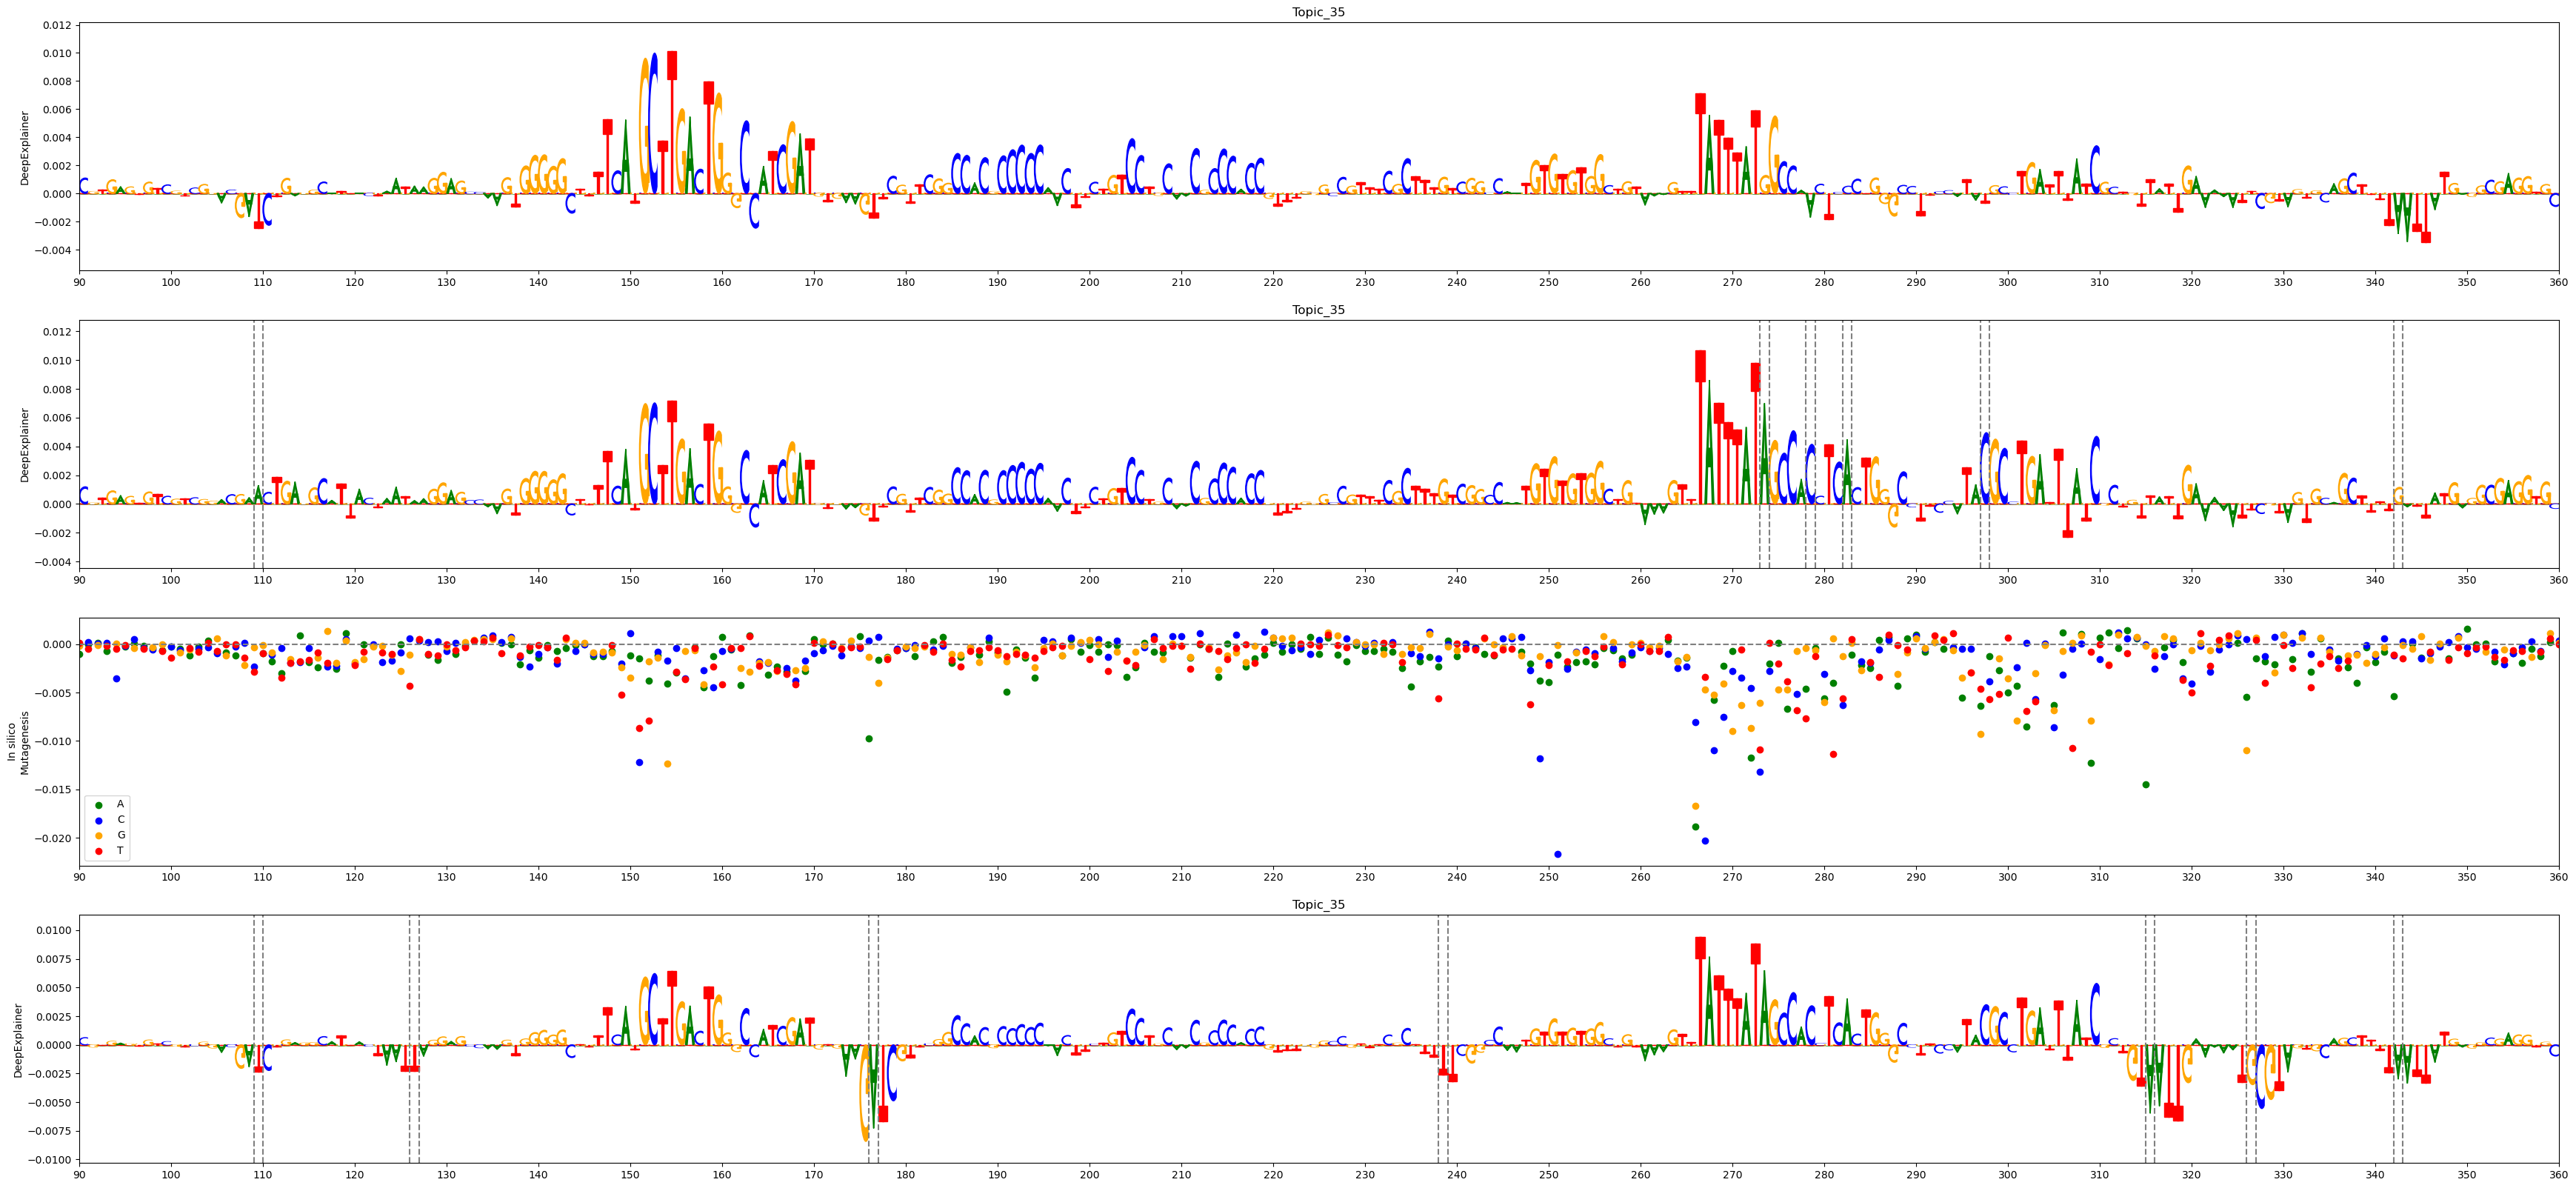

In [109]:
id_ =  'chrX:9786300-9786800'
muts = ["273_A","282_A","342_G","278_C","297_C","109_A"]
st = 90
end = 360


start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
ntrack = 4
fig = plt.figure(figsize=(43.2,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
ax_ = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)

repr_muts = ["342_A","109_T","176_A","315_A","126_T","326_G","238_T"]
for i, mut_ in enumerate(repr_muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 35)

for i, mut_ in enumerate(muts):
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

for i, mut_ in enumerate(repr_muts):
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")


ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax_.set_xlim([st,end])

plt.savefig("figures/near_enhancer_seq/FP910_deepexplainer_mut0_mut6_repr_st90_end360.pdf",transparent=True)


In [110]:
id_ =  'chrX:9786300-9786800'
muts = ["273_A","282_A","342_G","278_C","297_C","109_A"]
repr_muts = ["342_A","109_T","176_A","315_A","126_T","326_G","238_T"]

start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
for i, mut_ in enumerate(repr_muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

for nuc in start_x[0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")
print("")

AATGAATATTTTAAACCTTTCATTTCCATCTTTAATAACATAATTTTCATCTGGTTTAATTCGCTTTCCTCGACTTTCGATTGCATTTACCGTGAGTGTCGTCGGACGATCTGAGGCATTACTAATTAGGAGCCAAGTGGGGGCTTTTCATGCTTGACTGGGCCATCGATGTGAAGATCGTTCGGCCACGCCCCCAACTTCTGTCCTGCAACGCCCACCGTTTGGGCCGTTTCGCTTTTTCGGCCAATGTGTGTGGCTGTAAAGTTTATTTATAGCCACCTCACTGGGCCTTCCATACGCCTGATTTATCGCTGTAATTGAAAAATGCGTAGTGCAGCTTTTAATTATGAGGCGAGGTGCAAACAGAAAAATGGGTATATATTACAACAACATAAAAATAAAAGAGTGCAAAAATAAACAACATATAGCCGAGTGCAGAGTGAATAGTGCTGACTGCAAATCCCCTGGCAAACAAATAAATTGGAAAGTGGGCAAAACTG


### Performing additional in silico evolution mutations on the chosen region

0,1,2,3,4,5,0,1,2,3,4,

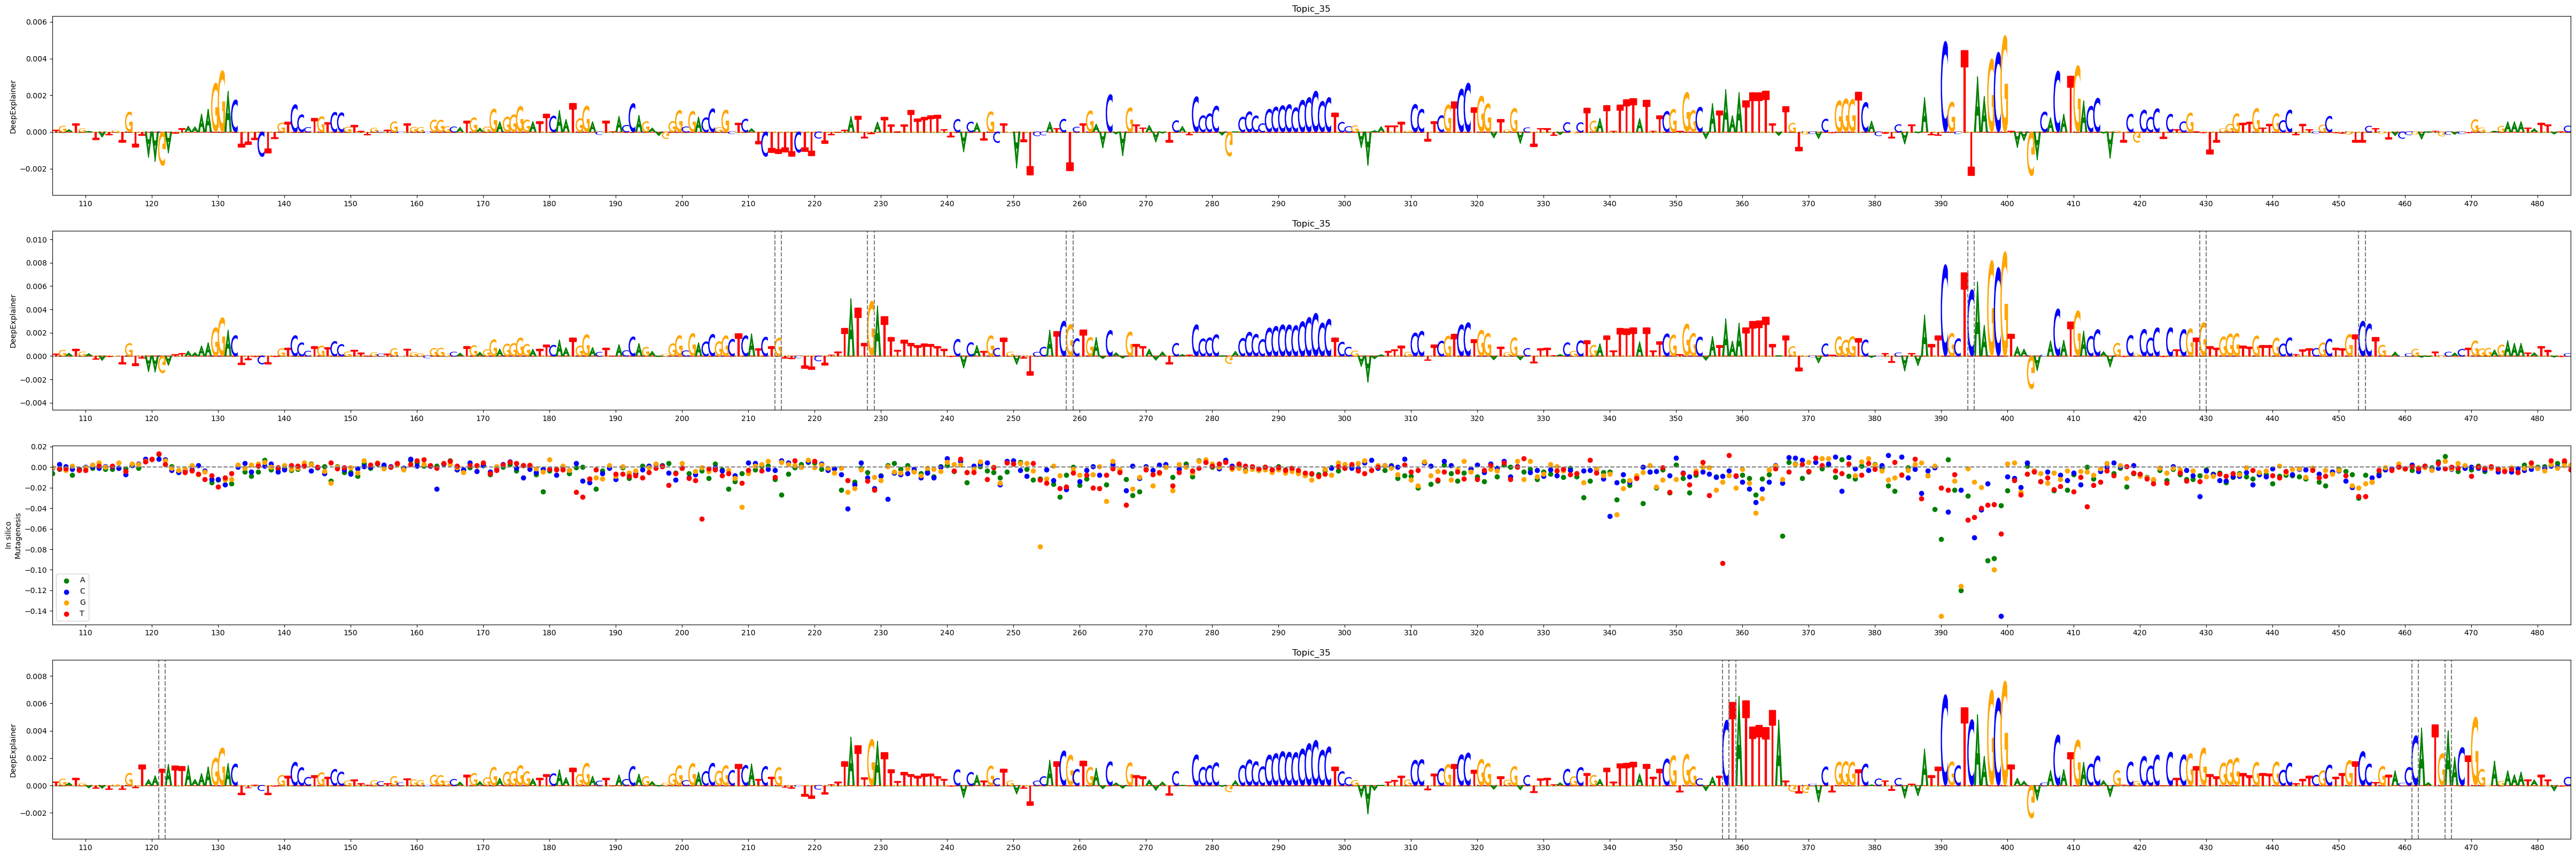

In [117]:
id_ =  'chrX:4010500-4011000'
muts = ["394_C","228_G","453_C","258_G","429_G","214_G"]
st = 105
end = 485


start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
ntrack = 4
fig = plt.figure(figsize=(60.8,ntrack*5))
ax1 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=1, seq_onehot=start_x, class_no = 35)
for i, mut_ in enumerate(muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax2 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=2, seq_onehot=start_x, class_no = 35)
ax_ = utils.plot_mutagenesis_givenax(model=model_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=3, seq_onehot=start_x, class_no = 35)

resc_muts = ["121_T","358_T","357_C","466_A","461_C"]
for i, mut_ in enumerate(resc_muts):
    print(i,end=",")
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
ax3 = utils.plot_deepexplainer_givenax(explainer=exp_dict["DeepFlyBrain"], fig=fig, ntrack=ntrack, track_no=4, seq_onehot=start_x, class_no = 35)

for i, mut_ in enumerate(muts):
    ax2.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax2.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

for i, mut_ in enumerate(resc_muts):
    ax3.axvline(x=int(mut_.split("_")[0]),linestyle="--",color="gray")
    ax3.axvline(x=int(mut_.split("_")[0])+1,linestyle="--",color="gray")

ax1.set_xlim([st,end])
ax2.set_xlim([st,end])
ax3.set_xlim([st,end])
ax_.set_xlim([st,end])

plt.savefig("figures/near_enhancer_seq/FP78_deepexplainer_mut0_mut6_mut11_st195_end465.pdf",transparent=True)


In [115]:
id_ =  'chrX:4010500-4011000'
muts = ["394_C","228_G","453_C","258_G","429_G","214_G"]
resc_muts = ["121_T","358_T","357_C","466_A","461_C"]

start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
for i, mut_ in enumerate(resc_muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')

for nuc in start_x[0]:
    if nuc[0]==1:
        print("A",end="")
    if nuc[1]==1:
        print("C",end="")
    if nuc[2]==1:
        print("G",end="")
    if nuc[3]==1:
        print("T",end="")
print("")

CAACAATAAAGATGGACAGATGTTGGCGATATGGAGTACTCGTTGTACACAGGGATGAGGCTTATAAATATATTTGCCTCACTTAAAGTGACCAAATTGTTATCATGATGATATGTGTTAATATTAAAAGGACTTTCTTGTCCCTGTCCGTTTGCTGCTGGCGGGCATGAGGAGGGGATTCAATGGACTTACCAGAAGGGCGACCGGCTCATCTGTTCTTCTTTTATTGATTTTTTTTTTTCACATGCTGATTCCATCGCTGAACAAGTTAAATCATCCCCAGACCCCCCCCCCCCCCTCCGAAAATTTGCCTTCGTCCTGGATGGACTTTTACGCTGATTTTTATTTCGTGGCAATCTATTTTTATGTGCACTGGGTCACTTCATAATTCGCTCAAGCGTAAGACACATGACCAAGTCGCCCTCTCGTGTTGGGTTGTTGCCTTTCGCTTGTCCTGTACCCAATGAACTGGGAGAAATATTATCATAGTAACGAAATCA


### Plotting prediction score of the selected near-enhancer sequences during in silico evolution and after repressor addition or further evolution

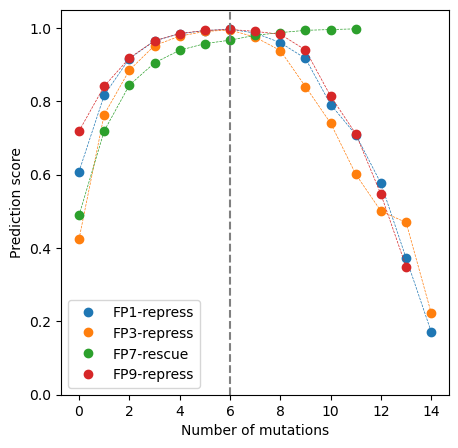

In [119]:
plt.figure(figsize=(5,5))
nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

id_ =  "chr3L:8670850-8671350"
muts = ["287_C","443_A","366_G","149_A","420_G","424_C",   "211_T","401_T","302_C","97_T","43_G","266_G","470_T","362_C"]
start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
pred = []
pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0,34])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0,34])
_ = plt.plot(pred,label="FP1-repress",linestyle="",marker="o",color="C"+str(0))
_ = plt.plot(pred,linestyle="--",linewidth=0.5,color="C"+str(0))

id_ =  'chrX:15547650-15548150'
muts = ["426_C","283_C","264_C","260_T","254_C","176_C", "238_A","154_G","373_C","167_A","140_A","176_A","221_A","418_A"]
start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
pred = []
pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0,34])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0,34])
_ = plt.plot(pred,label="FP3-repress",linestyle="",marker="o",color="C"+str(1))
_ = plt.plot(pred,linestyle="--",linewidth=0.5,color="C"+str(1))

id_ =  'chrX:4010500-4011000'
muts = ["394_C","228_G","453_C","258_G","429_G","214_G","121_T","358_T","357_C","466_A","461_C"]
start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
pred = []
pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0,34])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0,34])
_ = plt.plot(pred,label="FP7-rescue",linestyle="",marker="o",color="C"+str(2))
_ = plt.plot(pred,linestyle="--",linewidth=0.5,color="C"+str(2))

id_ =  'chrX:9786300-9786800'
muts = ["273_A","282_A","342_G","278_C","297_C","109_A","342_A","109_T","176_A","315_A","126_T","326_G","238_T"]
start_x = np.copy(w500_s50_dict["X"][w500_s50_dict["ids"]==id_])
pred = []
pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0,34])
for i, mut_ in enumerate(muts):
    start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')
    pred.append(model_dict["DeepFlyBrain"].predict(start_x)[0,34])
_ = plt.plot(pred,label="FP9-repress",linestyle="",marker="o",color="C"+str(3))
_ = plt.plot(pred,linestyle="--",linewidth=0.5,color="C"+str(3))

plt.axvline(x=6,linestyle="--",color='gray')
plt.legend()
plt.ylim(0,1.05)
plt.xlabel("Number of mutations")
plt.ylabel("Prediction score")
plt.savefig("figures/near_enhancer_seq/FP1_FP3_FP9_repress_FP7_rescue_prediction.pdf",transparent=True)
